In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

# Helper Stuff

In [2]:
# CPI: https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-
cpi_map = {
    2013: 233,
    2014: 236.7,
    2015: 237,
    2016: 240,
    2017: 245.1,
    2018: 251.1,
    2019: 255.7,
    2020: 258.8,
    2021: 271,
    2022: 292.7,
    2023: 304.7,
    2024: 313.7,
    2025: 322.3
}

In [3]:
cpt_spine_dict_old = {
    "cervical": {
        "decompression": ["63001", "63015", "63045", "63048", "63020", "63035", "63040", "63043", "63050", "63051", "63075", "63076", "63081", "63082"],
        "fusion": ["22551", "22552", "22554", "22585", "22590", "22595"],
        "instrumentation": ["22845", "22846", "22847", "22840", "22842", "22843", "22844", "22853", "22854", "22849"],
        "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"]
    },
    "thoracic": {
        "decompression": ["63003", "63016", "63046", "63048", "63085", "63086", "63087", "62380"],
        "fusion": ["22556", "22532", "22534", "22612", "22614", "22800", "22802", "22804", "22810", "22812"],
        "instrumentation": ["22840", "22842", "22843", "22844", "22845", "22846", "22847", "22853", "22854", "22849"],
        "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"]
    },
    "lumbar": {
        "decompression": ["63005", "63017", "63047", "63048", "63030", "63035", "63042", "63044", "63052", "63053", "62380", "63090", "63091"],
        "fusion": ["22558", "22585", "22533", "22534", "22612", "22614", "22630", "22632", "22633", "22634", "22800", "22802", "22804", "22810", "22812"],
        "instrumentation": ["22840", "22842", "22843", "22844", "22845", "22846", "22847", "22853", "22854", "22859", "22849"],
        "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"]
    }
}

cpt_spine = {
    "instrumentation": ["22840", "22842", "22843", "22844", "22845", "22846", "22847", "22853", "22854", "22859", "22849"],
    "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"],
    "decompression_add_ons": ["63048", "63035"],
    "decompression_cervical": ["63001", "63015", "63045", "63020", "63040", "63043", "63050", "63051", "63075", "63076", "63081", "63082"],
    "decompression_thoracic": ["63003", "63016", "63046", "63085", "63086", "63087"],
    "decompression_lumbar": ["63005", "63017", "63047", "63030", "63042", "63044", "63052", "63053", "62380", "63090", "63091"],
    "fusion_add_ons": ["22585", "22614", "22534"],
    "fusion_multiple_regions": ["22800", "22802", "22804", "22810", "22812"],
    "fusion_cervical": ["22551", "22552", "22554", "22590", "22595"],
    "fusion_thoracic": ["22556", "22532"],
    "fusion_lumbar": ["22558", "22533", "22612", "22630", "22632", "22633", "22634"],
}

cpt_neurovasc = {
    'aneurysm_coiling_embo': ['61624', '61626'],
    'embo_dr': ['75894', '75898'],
    'thrombectomy': ['61645'],
    # 'thrombectomy_nonintracranial': ['37184', '37185', '37186'],
    'intracranial_stent_angioplasty': ['61630', '61635', '61640', '61641', '61642'],
    'intraarterial_pharm_infusion': ['61650', '61651'],
    'temp_balloon': ['61623'],
    'cerebral_angio': ['36221', '36222', '36223', '36224', '36225', '36226', '36227', '36228']
}

# Ignore cerebral angio codes for now
ignore_codes = ['36221', '36222', '36223', '36224', '36225', '36226', '36227', '36228']

cpt_map = {}

for category, codes in {**cpt_spine, **cpt_neurovasc}.items():
    for code in codes:
        if code not in ignore_codes:
            cpt_map[int(code)] = category

In [4]:
current_dir = os.getcwd()

# Load Data

In [5]:
spine_data = pd.read_csv(os.path.join(current_dir, "processed-data", "spine_cpt_processed.csv"))
neurovasc_data = pd.read_csv(os.path.join(current_dir, "processed-data", "neurovasc_cpt_processed.csv"))
all_neurovasc_data = pd.read_csv(os.path.join(current_dir, "processed-data", "neurovasc_cpt_processed_all_specialities.csv"))
all_spine_data = pd.read_csv(os.path.join(current_dir, "processed-data", "spine_cpt_processed_all_specialities.csv"))

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_52586/1119335657.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  all_spine_data = pd.read_csv(os.path.join(current_dir, "processed-data", "spine_cpt_processed_all_specialities.csv"))


In [6]:
spine_data['Tot_Srvcs_Spend'] = spine_data['Tot_Srvcs'] * spine_data['Avg_Mdcr_Stdzd_Amt'] 
neurovasc_data['Tot_Srvcs_Spend'] = neurovasc_data['Tot_Srvcs'] * neurovasc_data['Avg_Mdcr_Stdzd_Amt'] 
all_neurovasc_data['Tot_Srvcs_Spend'] = all_neurovasc_data['Tot_Srvcs'] * all_neurovasc_data['Avg_Mdcr_Stdzd_Amt'] 
all_spine_data['Tot_Srvcs_Spend'] = all_spine_data['Tot_Srvcs'] * all_spine_data['Avg_Mdcr_Stdzd_Amt'] 

In [7]:
spine_data['Tot_Pymt'] = spine_data['Tot_Srvcs'] * spine_data['Avg_Mdcr_Pymt_Amt'] 
neurovasc_data['Tot_Pymt'] = neurovasc_data['Tot_Srvcs'] * neurovasc_data['Avg_Mdcr_Pymt_Amt'] 
all_neurovasc_data['Tot_Pymt'] = all_neurovasc_data['Tot_Srvcs'] * all_neurovasc_data['Avg_Mdcr_Pymt_Amt'] 
all_spine_data['Tot_Pymt'] = all_spine_data['Tot_Srvcs'] * all_spine_data['Avg_Mdcr_Pymt_Amt'] 

In [8]:
spine_data = spine_data[["HCPCS_Cd", "Rndrng_Prvdr_Type", "Tot_Srvcs", "Avg_Mdcr_Stdzd_Amt", "Rndrng_NPI", "Tot_Srvcs_Spend", "year", "Tot_Pymt", "Avg_Mdcr_Pymt_Amt"]]
neurovasc_data = neurovasc_data[["HCPCS_Cd", "Rndrng_Prvdr_Type", "Tot_Srvcs", "Avg_Mdcr_Stdzd_Amt", "Rndrng_NPI", "Tot_Srvcs_Spend", "year", "Tot_Pymt", "Avg_Mdcr_Pymt_Amt"]]
all_neurovasc_data = all_neurovasc_data[["HCPCS_Cd", "Rndrng_Prvdr_Type", "Tot_Srvcs", "Avg_Mdcr_Stdzd_Amt", "Rndrng_NPI", "Tot_Srvcs_Spend", "year", "Tot_Pymt", "Avg_Mdcr_Pymt_Amt"]]
all_spine_data = all_spine_data[["HCPCS_Cd", "Rndrng_Prvdr_Type", "Tot_Srvcs", "Avg_Mdcr_Stdzd_Amt", "Rndrng_NPI", "Tot_Srvcs_Spend", "year", "Tot_Pymt", "Avg_Mdcr_Pymt_Amt"]]

In [9]:
for data in [spine_data, neurovasc_data, all_neurovasc_data, all_spine_data]:
    data['procedure'] = data['HCPCS_Cd'].map(cpt_map)

In [10]:
# Filter to only spine surgeons (defined as someone who has performed at least 1000 procedures over 10 year period)
# spine_counts = pd.read_csv(os.path.join(current_dir, "processed-data", "spine_counts.csv"))
# spine_counts = spine_counts[spine_counts['total_spine_services'] >= 1000]

# spine_data = spine_data[spine_data['Rndrng_NPI'].isin(spine_counts['Rndrng_NPI'])].reset_index(drop=True)

In [11]:
spine_data.shape

(120099, 10)

# Analysis

In [12]:
groupby_key = 'procedure'

In [13]:
# Group by procedure and year, and summarize
util_2023_2013_adj_spine = (
    spine_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(
        Sum_Utilization=('Tot_Srvcs', 'sum'),
        Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
        Sum_Pymt=('Tot_Pymt', 'sum'),
        Sum_Provider=('Rndrng_NPI', lambda x: x.nunique())
    )
)

util_2023_2013_adj_neurovasc = (
    neurovasc_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(Sum_Utilization=('Tot_Srvcs', 'sum'),
         Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
         Sum_Pymt=('Tot_Pymt', 'sum'),
         Sum_Provider=('Rndrng_NPI', lambda x: x.nunique()))
)

util_2023_2013_adj_neurovasc_all = (
    all_neurovasc_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(Sum_Utilization=('Tot_Srvcs', 'sum'),
         Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
         Sum_Pymt=('Tot_Pymt', 'sum'),
         Sum_Provider=('Rndrng_NPI', lambda x: x.nunique()))
)

util_2023_2013_adj_spine_all = (
    all_spine_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(Sum_Utilization=('Tot_Srvcs', 'sum'),
         Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
         Sum_Pymt=('Tot_Pymt', 'sum'),
         Sum_Provider=('Rndrng_NPI', lambda x: x.nunique()))
)

In [14]:
util_2023_2013_adj_spine['CPI'] = util_2023_2013_adj_spine['year'].map(cpi_map).fillna(0)
util_2023_2013_adj_neurovasc['CPI'] = util_2023_2013_adj_neurovasc['year'].map(cpi_map).fillna(0)
util_2023_2013_adj_neurovasc_all['CPI'] = util_2023_2013_adj_neurovasc_all['year'].map(cpi_map).fillna(0)
util_2023_2013_adj_spine_all['CPI'] = util_2023_2013_adj_spine_all['year'].map(cpi_map).fillna(0)

In [15]:
util_2023_2013_adj_spine['Sum_Spend_adjusted'] = util_2023_2013_adj_spine['Sum_Spend'] / util_2023_2013_adj_spine['CPI'] * cpi_map[2023]
util_2023_2013_adj_neurovasc['Sum_Spend_adjusted'] = util_2023_2013_adj_neurovasc['Sum_Spend'] / util_2023_2013_adj_neurovasc['CPI'] * cpi_map[2023]
util_2023_2013_adj_neurovasc_all['Sum_Spend_adjusted'] = util_2023_2013_adj_neurovasc_all['Sum_Spend'] / util_2023_2013_adj_neurovasc_all['CPI'] * cpi_map[2023]
util_2023_2013_adj_spine_all['Sum_Spend_adjusted'] = util_2023_2013_adj_spine_all['Sum_Spend'] / util_2023_2013_adj_spine_all['CPI'] * cpi_map[2023]

In [16]:
util_2023_2013_adj_spine['Sum_Pymt_adjusted'] = util_2023_2013_adj_spine['Sum_Pymt'] / util_2023_2013_adj_spine['CPI'] * cpi_map[2023]
util_2023_2013_adj_neurovasc['Sum_Pymt_adjusted'] = util_2023_2013_adj_neurovasc['Sum_Pymt'] / util_2023_2013_adj_neurovasc['CPI'] * cpi_map[2023]
util_2023_2013_adj_neurovasc_all['Sum_Pymt_adjusted'] = util_2023_2013_adj_neurovasc_all['Sum_Pymt'] / util_2023_2013_adj_neurovasc_all['CPI'] * cpi_map[2023]
util_2023_2013_adj_spine_all['Sum_Pymt_adjusted'] = util_2023_2013_adj_spine_all['Sum_Pymt'] / util_2023_2013_adj_spine_all['CPI'] * cpi_map[2023]

In [17]:
util_2023_2013_adj_spine['Avg_Price_per_service_adjusted'] = (
    util_2023_2013_adj_spine['Sum_Spend_adjusted'] / util_2023_2013_adj_spine['Sum_Utilization']
)

util_2023_2013_adj_neurovasc['Avg_Price_per_service_adjusted'] = (
    util_2023_2013_adj_neurovasc['Sum_Spend_adjusted'] / util_2023_2013_adj_neurovasc['Sum_Utilization']
)

util_2023_2013_adj_neurovasc_all['Avg_Price_per_service_adjusted'] = (
    util_2023_2013_adj_neurovasc_all['Sum_Spend_adjusted'] / util_2023_2013_adj_neurovasc_all['Sum_Utilization']
)

util_2023_2013_adj_spine_all['Avg_Price_per_service_adjusted'] = (
    util_2023_2013_adj_spine_all['Sum_Spend_adjusted'] / util_2023_2013_adj_spine_all['Sum_Utilization']
)

In [156]:
# spine_costs = {}
# for _, row in spine_data.iterrows():
#     if row['year'] not in spine_costs:
#         spine_costs[row['year']] = {}

#     if row['procedure'] not in spine_costs[row['year']]:
#         spine_costs[row['year']][row['procedure']] = []

#     cost_per_proc = row['Tot_Srvcs_Spend'] / row['Tot_Srvcs']
#     cost_per_proc_adj = cost_per_proc / cpi_map[row['year']] * cpi_map[2023]
#     spine_costs[row['year']][row['procedure']].extend([cost_per_proc_adj] * int(row['Tot_Srvcs']))

# neurovasc_costs = {}
# for _, row in neurovasc_data.iterrows():
#     if row['year'] not in neurovasc_costs:
#         neurovasc_costs[row['year']] = {}

#     if row['procedure'] not in neurovasc_costs[row['year']]:
#         neurovasc_costs[row['year']][row['procedure']] = []

#     cost_per_proc = row['Tot_Srvcs_Spend'] / row['Tot_Srvcs']
#     cost_per_proc_adj = cost_per_proc / cpi_map[row['year']] * cpi_map[2023]
#     neurovasc_costs[row['year']][row['procedure']].extend([cost_per_proc_adj] * int(row['Tot_Srvcs']))

## Average Standardized Payment

In [157]:
spine_costs = {}
for _, row in spine_data.iterrows():
    if row['year'] not in spine_costs:
        spine_costs[row['year']] = {}

    if row['procedure'] not in spine_costs[row['year']]:
        spine_costs[row['year']][row['procedure']] = []

    cost_per_proc = row['Avg_Mdcr_Stdzd_Amt'] # row['Tot_Srvcs_Spend'] / row['Tot_Srvcs']
    cost_per_proc_adj = cost_per_proc / cpi_map[row['year']] * cpi_map[2023]
    spine_costs[row['year']][row['procedure']].append(cost_per_proc_adj)

neurovasc_costs = {}
for _, row in neurovasc_data.iterrows():
    if row['year'] not in neurovasc_costs:
        neurovasc_costs[row['year']] = {}

    if row['procedure'] not in neurovasc_costs[row['year']]:
        neurovasc_costs[row['year']][row['procedure']] = []

    cost_per_proc = row['Avg_Mdcr_Stdzd_Amt'] # row['Tot_Srvcs_Spend'] / row['Tot_Srvcs']
    cost_per_proc_adj = cost_per_proc / cpi_map[row['year']] * cpi_map[2023]
    neurovasc_costs[row['year']][row['procedure']].append(cost_per_proc_adj)

In [158]:
for year in spine_costs:
    for proc in spine_costs[year]:
        spine_costs[year][proc] = np.array(spine_costs[year][proc]).std(ddof=1) / np.sqrt(len(spine_costs[year][proc]))

for year in neurovasc_costs:
    for proc in neurovasc_costs[year]:
        neurovasc_costs[year][proc] = np.array(neurovasc_costs[year][proc]).std(ddof=1) / np.sqrt(len(neurovasc_costs[year][proc]))

/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [159]:
spine_costs_sem = []
for year in spine_costs:
    for proc in spine_costs[year]:
        spine_costs_sem.append([year, proc, spine_costs[year][proc]])

neurovasc_costs_sem = []
for year in neurovasc_costs:
    for proc in neurovasc_costs[year]:
        neurovasc_costs_sem.append([year, proc, neurovasc_costs[year][proc]])

In [160]:
util_2023_2013_adj_spine = util_2023_2013_adj_spine.merge(pd.DataFrame(spine_costs_sem, columns=['year', 'procedure', 'SEM']), on=['year', 'procedure'], how='left')
util_2023_2013_adj_neurovasc = util_2023_2013_adj_neurovasc.merge(pd.DataFrame(neurovasc_costs_sem, columns=['year', 'procedure', 'SEM']), on=['year', 'procedure'], how='left')

In [161]:
util_2023_2013_adj_spine['CI_lower'] = util_2023_2013_adj_spine['Avg_Price_per_service_adjusted'] - 1.96 * util_2023_2013_adj_spine['SEM']
util_2023_2013_adj_spine['CI_upper'] = util_2023_2013_adj_spine['Avg_Price_per_service_adjusted'] + 1.96 * util_2023_2013_adj_spine['SEM']

util_2023_2013_adj_neurovasc['CI_lower'] = util_2023_2013_adj_neurovasc['Avg_Price_per_service_adjusted'] - 1.96 * util_2023_2013_adj_neurovasc['SEM']
util_2023_2013_adj_neurovasc['CI_upper'] = util_2023_2013_adj_neurovasc['Avg_Price_per_service_adjusted'] + 1.96 * util_2023_2013_adj_neurovasc['SEM']

In [162]:
sns.set_theme(style="whitegrid", font_scale=1.1)

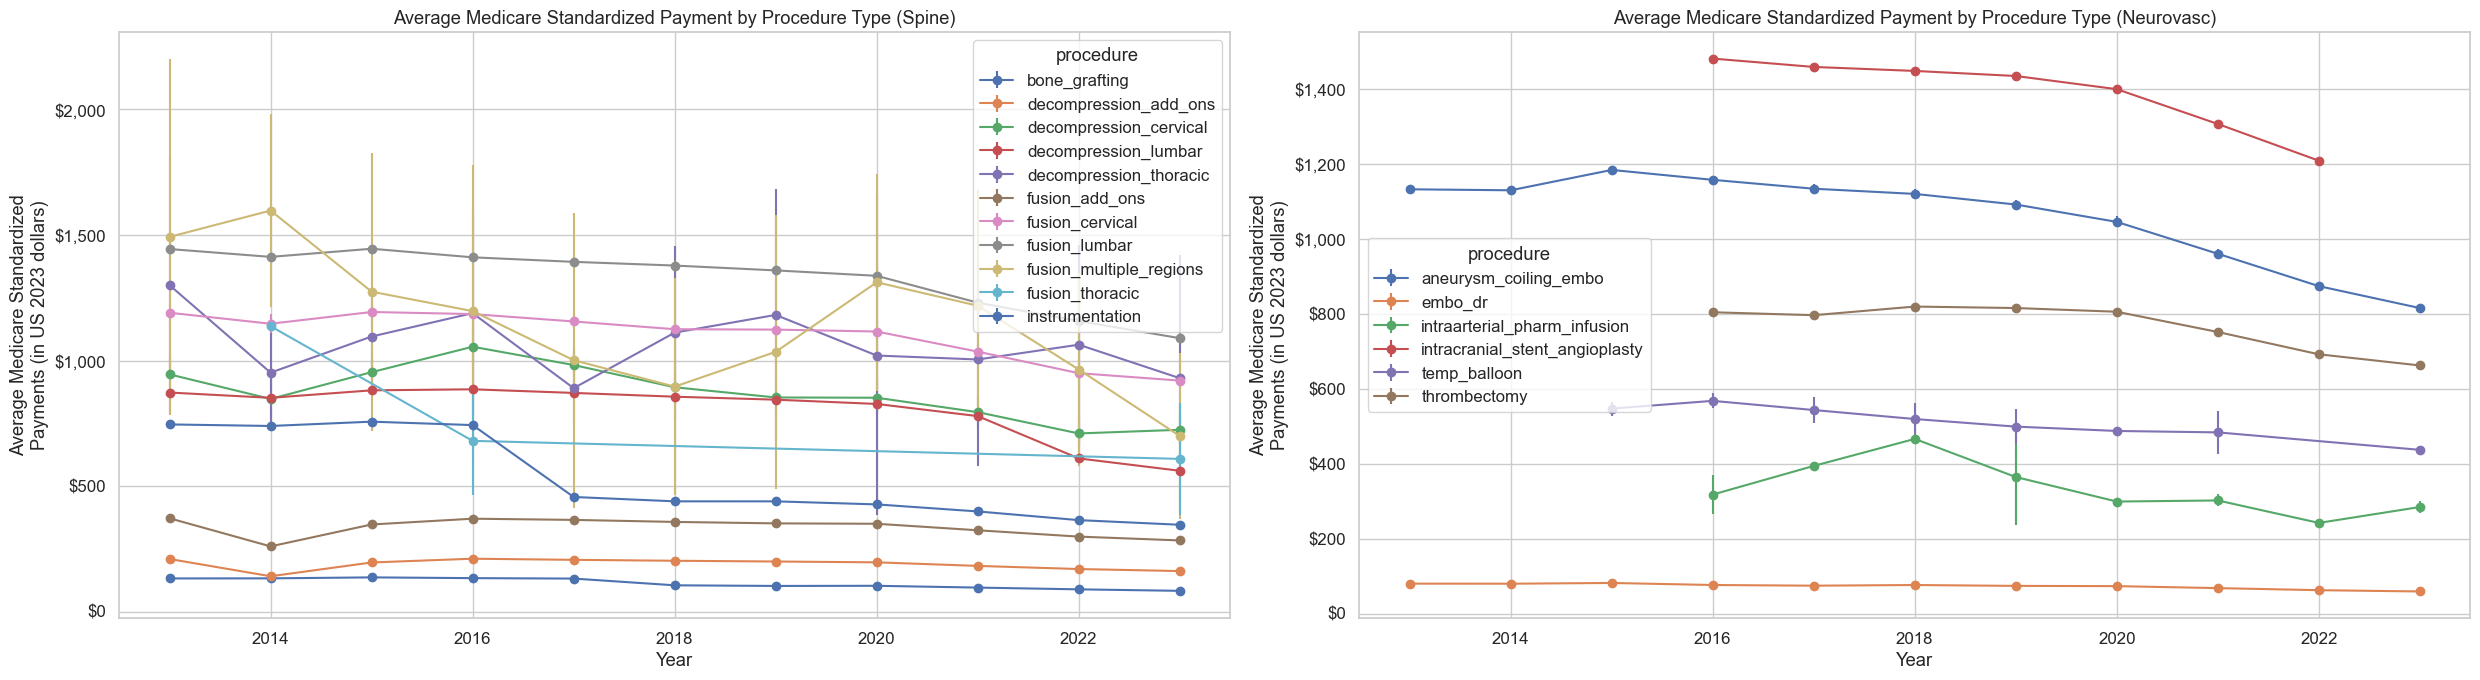

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year']
    y = df_sorted['Avg_Price_per_service_adjusted']

    # Compute error bars from CI bounds
    yerr = [
        y - df_sorted['CI_lower'],
        df_sorted['CI_upper'] - y
    ]

    axs[0].errorbar(
        x,
        y,
        yerr=yerr,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

axs[0].legend(title=groupby_key)
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[0].set_title("Average Medicare Standardized Payment by Procedure Type (Spine)")

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year']
    y = df_sorted['Avg_Price_per_service_adjusted']

    # Compute error bars from CI bounds
    yerr = [
        y - df_sorted['CI_lower'],
        df_sorted['CI_upper'] - y
    ]

    axs[1].errorbar(
        x,
        y,
        yerr=yerr,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

axs[1].legend(title=groupby_key)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[1].set_title("Average Medicare Standardized Payment by Procedure Type (Neurovasc)")

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

## Avg Payment per Procedure Growth Rate

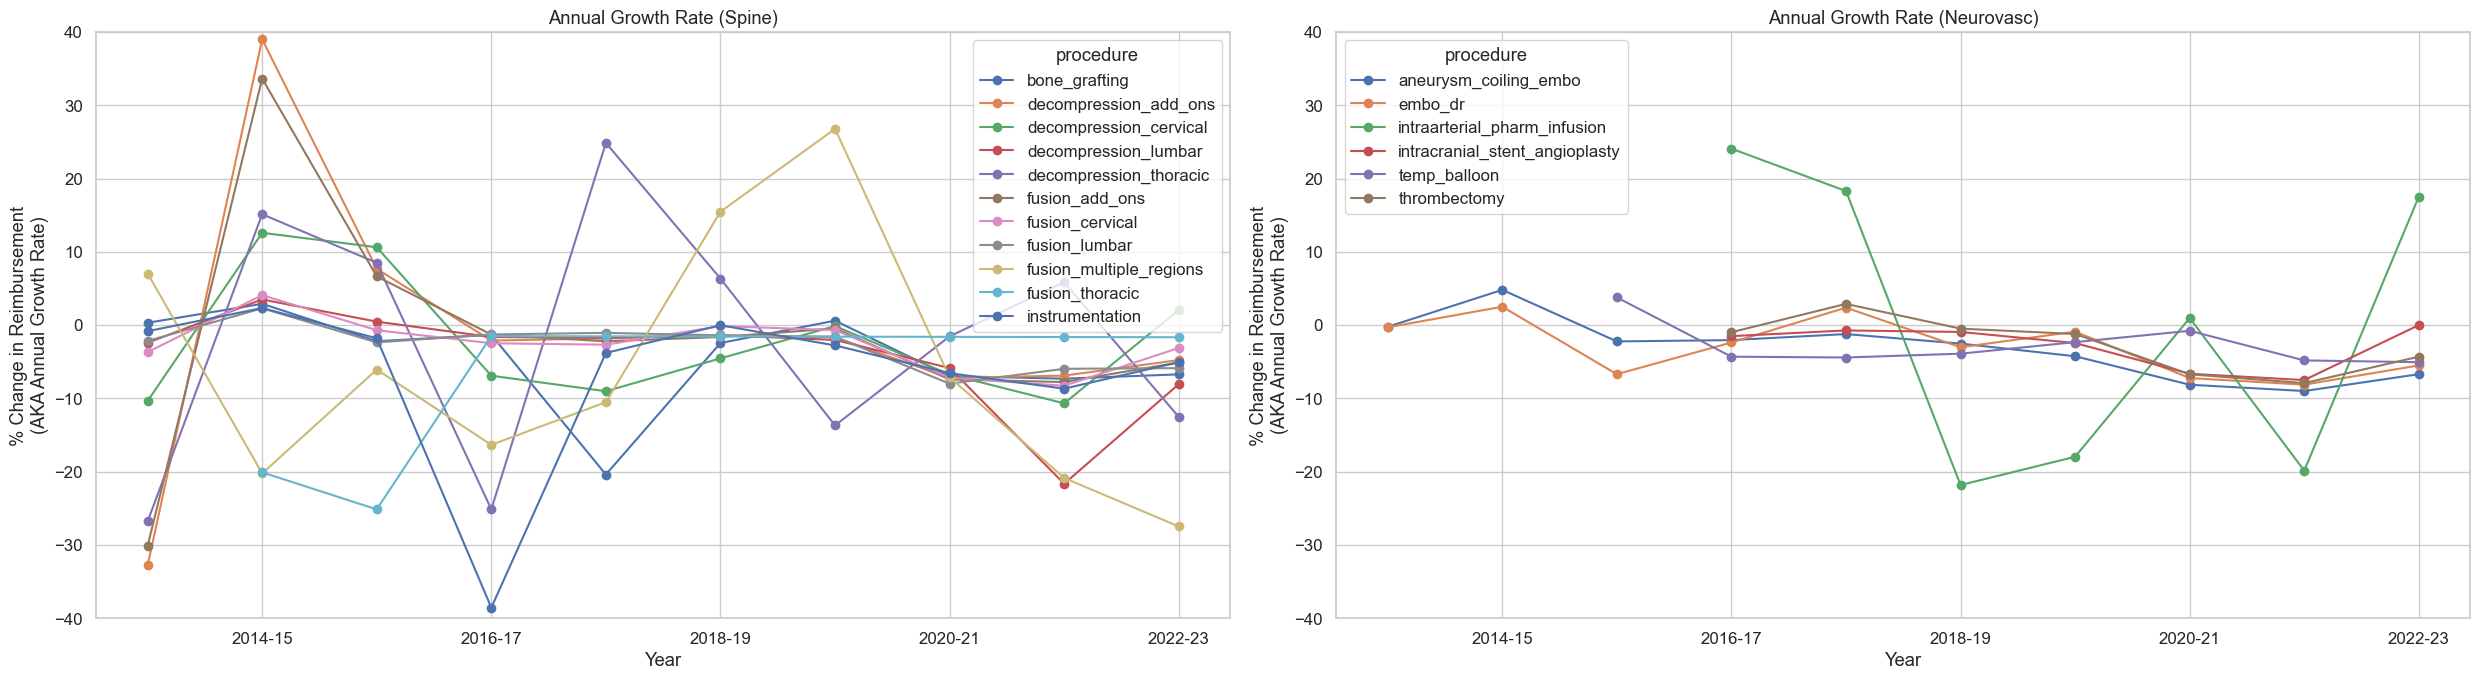

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

aagr_by_procedure_spine = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    axs[0].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_spine.append([label, np.nanmean(delta)])

axs[0].legend(title=groupby_key)
axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("% Change in Reimbursement\n(AKA Annual Growth Rate)")
axs[0].set_ylim([-40, 40])
axs[0].set_title("Annual Growth Rate (Spine)")

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

aagr_by_procedure_neurovasc = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()

    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    axs[1].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_neurovasc.append([label, np.nanmean(delta)])

axs[1].legend(title=groupby_key)
axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("% Change in Reimbursement\n(AKA Annual Growth Rate)")
axs[1].set_ylim([-40, 40])
axs[1].set_title("Annual Growth Rate (Neurovasc)")

plt.tight_layout()

In [165]:
pd.DataFrame(aagr_by_procedure_spine + aagr_by_procedure_neurovasc, columns=['procedure', 'AAGR (%)']).sort_values(by=['AAGR (%)'])

,procedure,AAGR (%)
10,instrumentation,-6.575782
9,fusion_thoracic,-6.256198
8,fusion_multiple_regions,-5.933132
0,bone_grafting,-4.354825
3,decompression_lumbar,-4.075864
11,aneurysm_coiling_embo,-3.153828
12,embo_dr,-2.927184
14,intracranial_stent_angioplasty,-2.822756
7,fusion_lumbar,-2.739311
15,temp_balloon,-2.730433


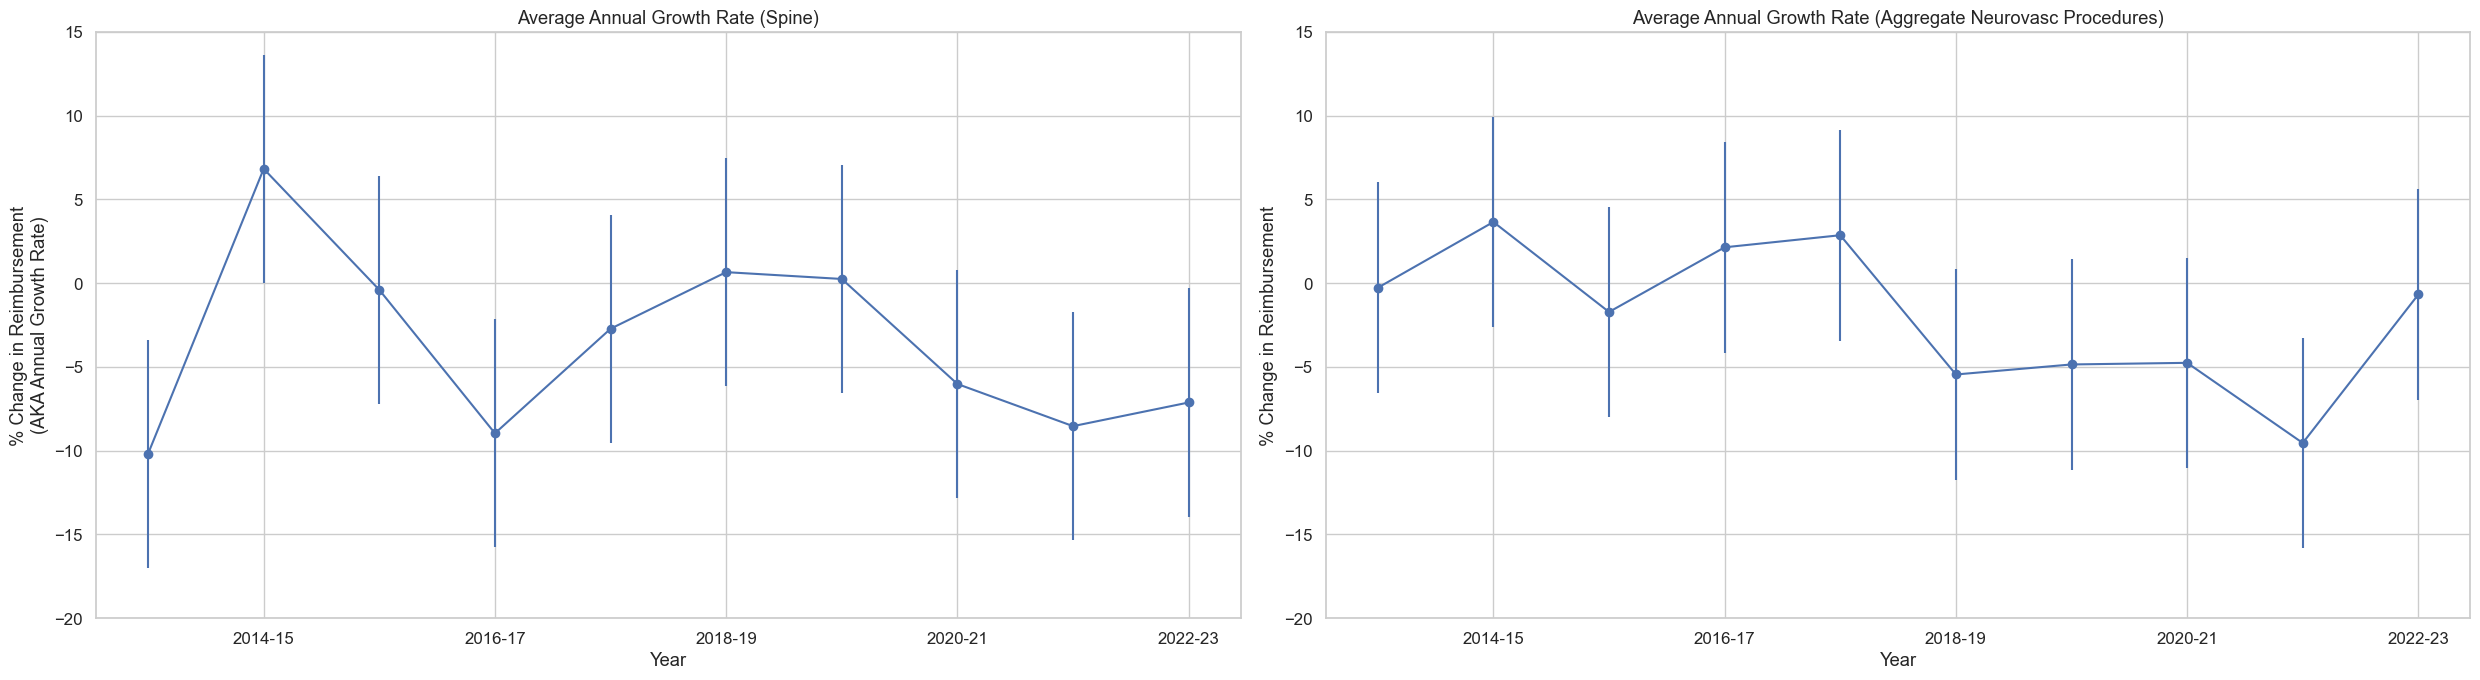

In [215]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[0].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("% Change in Reimbursement\n(AKA Annual Growth Rate)")
axs[0].set_ylim([-20, 15])
axs[0].set_title("Average Annual Growth Rate (Spine)")

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[1].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("% Change in Reimbursement")
axs[1].set_ylim([-20, 15])
axs[1].set_title("Average Annual Growth Rate (Aggregate Neurovasc Procedures)")

plt.tight_layout()

## Avg Payment per Procedure $ Growth

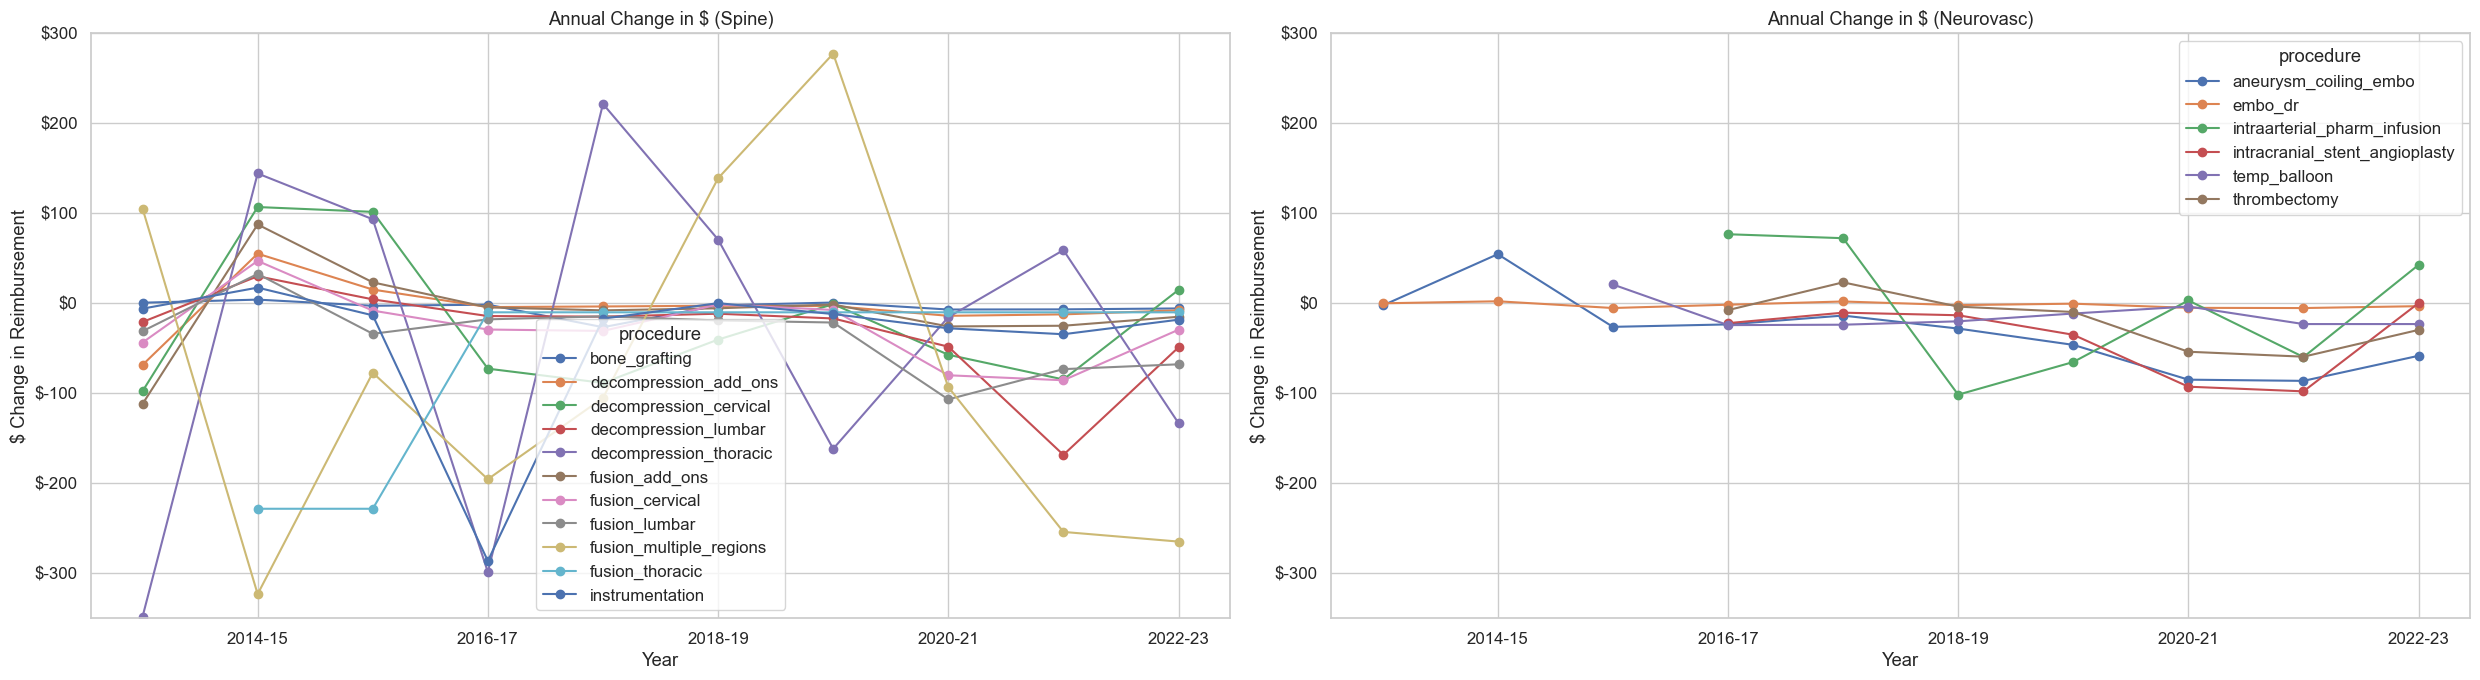

In [212]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

aagr_by_procedure_spine = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    axs[0].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_spine.append([label, np.nanmean(delta)])

axs[0].legend(title=groupby_key)
axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("$ Change in Reimbursement")
axs[0].set_ylim([-350, 300])
axs[0].set_title("Annual Change in $ (Spine)")

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

aagr_by_procedure_neurovasc = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()

    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    axs[1].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_neurovasc.append([label, np.nanmean(delta)])

axs[1].legend(title=groupby_key)
axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("$ Change in Reimbursement")
axs[1].set_ylim([-350, 300])
axs[1].set_title("Annual Change in $ (Neurovasc)")

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

In [214]:
temp = pd.DataFrame(aagr_by_procedure_spine + aagr_by_procedure_neurovasc, columns=['procedure', 'Change in $']).sort_values(by=['Change in $'])
temp['Change in $'] = temp['Change in $'].apply(lambda x: f'${x:,.2f}'.format(x))
temp

,procedure,Change in $
8,fusion_multiple_regions,$-79.32
9,fusion_thoracic,$-58.73
10,instrumentation,$-39.97
14,intracranial_stent_angioplasty,$-38.93
4,decompression_thoracic,$-37.02
7,fusion_lumbar,$-35.49
11,aneurysm_coiling_embo,$-31.70
3,decompression_lumbar,$-31.15
6,fusion_cervical,$-27.03
2,decompression_cervical,$-22.07


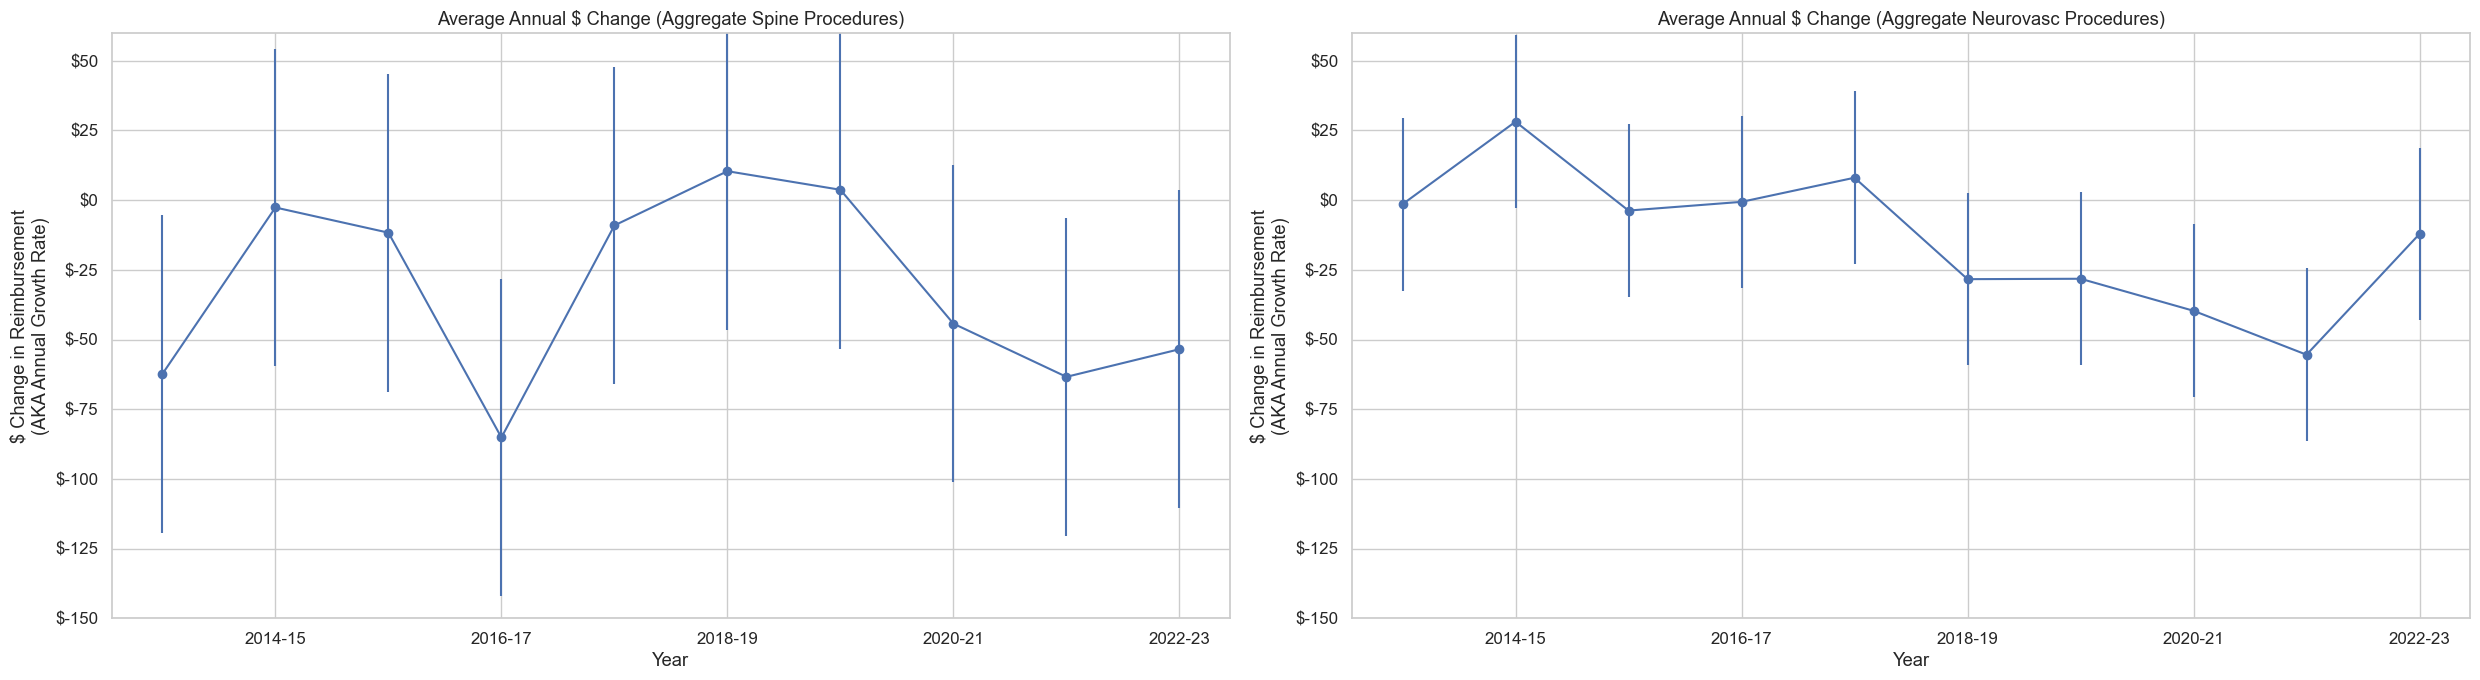

In [213]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[0].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("$ Change in Reimbursement\n(AKA Annual Growth Rate)")
axs[0].set_ylim([-150, 60])
axs[0].set_title("Average Annual $ Change (Aggregate Spine Procedures)")

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Avg_Price_per_service_adjusted'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[1].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("$ Change in Reimbursement\n(AKA Annual Growth Rate)")
axs[1].set_ylim([-150, 60])
axs[1].set_title("Average Annual $ Change (Aggregate Neurovasc Procedures)")

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

## Utilization per Year

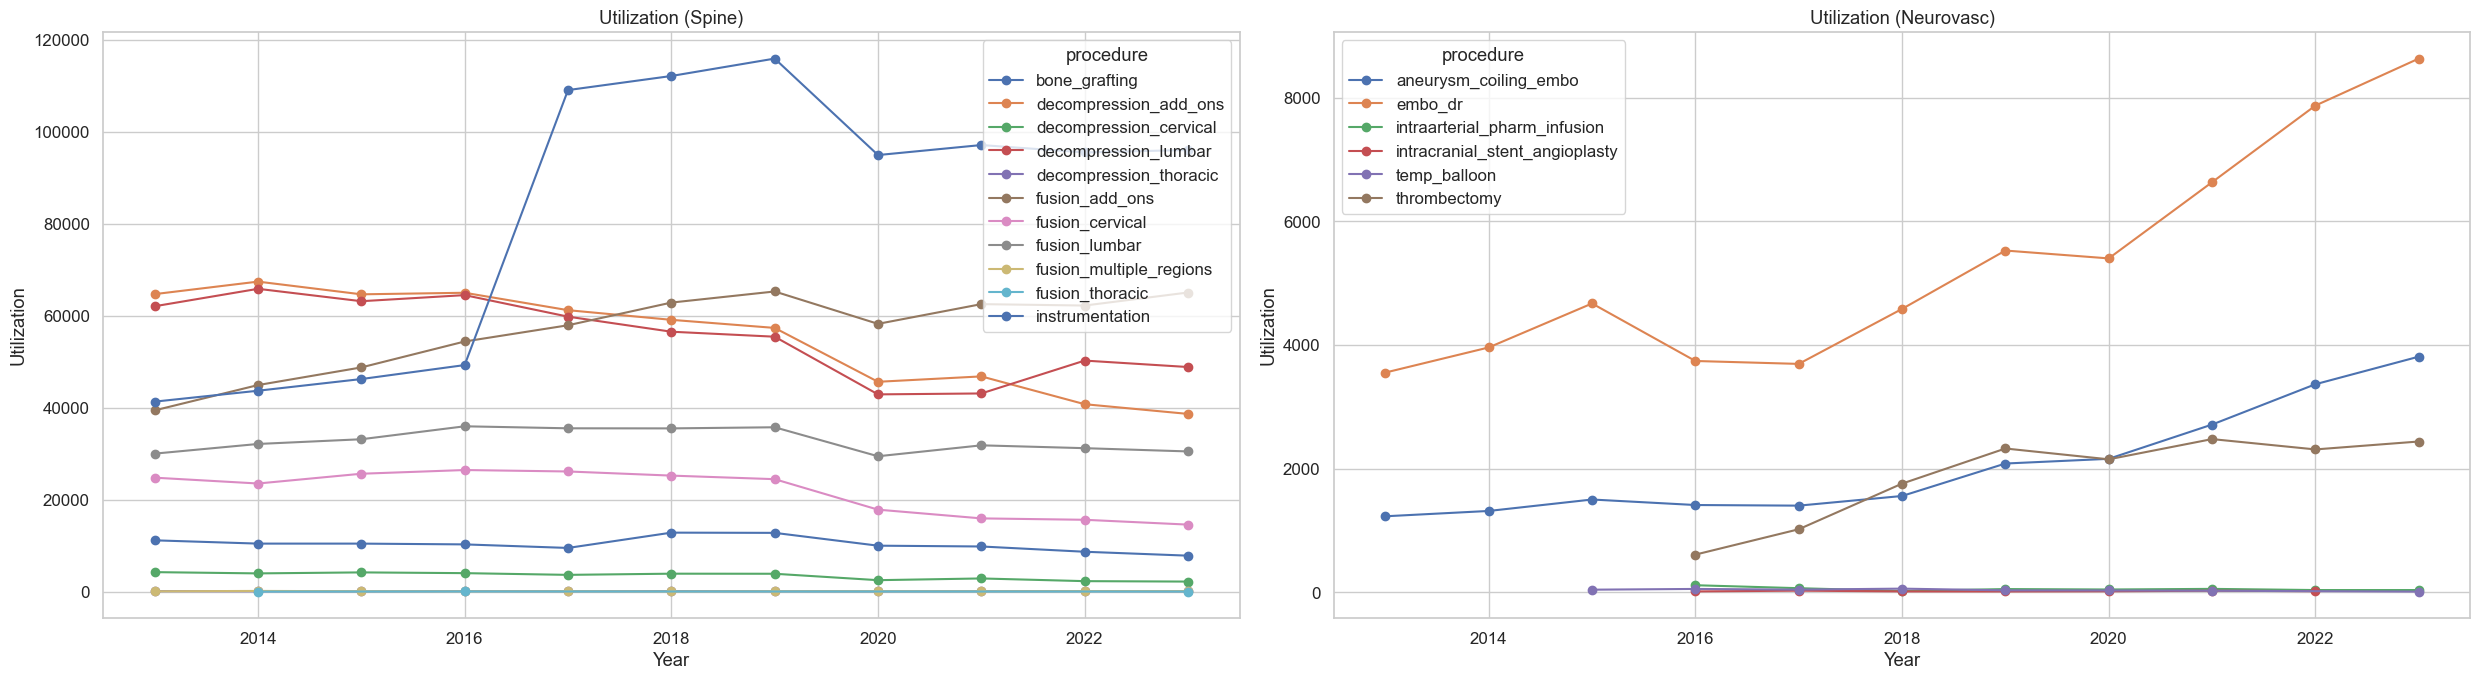

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year']
    y = df_sorted['Sum_Utilization']

    axs[0].plot(
        x,
        y,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

axs[0].legend(title=groupby_key)
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Utilization")
axs[0].set_title("Utilization (Spine)")

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year']
    y = df_sorted['Sum_Utilization']

    axs[1].plot(
        x,
        y,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

axs[1].legend(title=groupby_key)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Utilization")
axs[1].set_title("Utilization (Neurovasc)")

plt.tight_layout()

## Total Payment

In [170]:
spine_costs = {}
for _, row in spine_data.iterrows():
    if row['year'] not in spine_costs:
        spine_costs[row['year']] = {}

    if row['procedure'] not in spine_costs[row['year']]:
        spine_costs[row['year']][row['procedure']] = []

    pymt_per_proc = row['Tot_Pymt']
    cost_per_proc_adj = pymt_per_proc / cpi_map[row['year']] * cpi_map[2023]
    spine_costs[row['year']][row['procedure']].append(cost_per_proc_adj)

neurovasc_costs = {}
for _, row in neurovasc_data.iterrows():
    if row['year'] not in neurovasc_costs:
        neurovasc_costs[row['year']] = {}

    if row['procedure'] not in neurovasc_costs[row['year']]:
        neurovasc_costs[row['year']][row['procedure']] = []

    pymt_per_proc = row['Tot_Pymt']
    cost_per_proc_adj = pymt_per_proc / cpi_map[row['year']] * cpi_map[2023]
    neurovasc_costs[row['year']][row['procedure']].append(cost_per_proc_adj)

In [171]:
for year in spine_costs:
    for proc in spine_costs[year]:
        spine_costs[year][proc] = np.array(spine_costs[year][proc]).std(ddof=1) / np.sqrt(len(spine_costs[year][proc]))

for year in neurovasc_costs:
    for proc in neurovasc_costs[year]:
        neurovasc_costs[year][proc] = np.array(neurovasc_costs[year][proc]).std(ddof=1) / np.sqrt(len(neurovasc_costs[year][proc]))

/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [172]:
spine_costs_sem = []
for year in spine_costs:
    for proc in spine_costs[year]:
        spine_costs_sem.append([year, proc, spine_costs[year][proc]])

neurovasc_costs_sem = []
for year in neurovasc_costs:
    for proc in neurovasc_costs[year]:
        neurovasc_costs_sem.append([year, proc, neurovasc_costs[year][proc]])

In [173]:
util_2023_2013_adj_spine = util_2023_2013_adj_spine.merge(pd.DataFrame(spine_costs_sem, columns=['year', 'procedure', 'SEM_pymt']), on=['year', 'procedure'], how='left')
util_2023_2013_adj_neurovasc = util_2023_2013_adj_neurovasc.merge(pd.DataFrame(neurovasc_costs_sem, columns=['year', 'procedure', 'SEM_pymt']), on=['year', 'procedure'], how='left')

In [174]:
util_2023_2013_adj_spine['CI_lower_pymt'] = util_2023_2013_adj_spine['Sum_Pymt'] - 1.96 * util_2023_2013_adj_spine['SEM_pymt']
util_2023_2013_adj_spine['CI_upper_pymt'] = util_2023_2013_adj_spine['Sum_Pymt'] + 1.96 * util_2023_2013_adj_spine['SEM_pymt']

util_2023_2013_adj_neurovasc['CI_lower_pymt'] = util_2023_2013_adj_neurovasc['Sum_Pymt'] - 1.96 * util_2023_2013_adj_neurovasc['SEM_pymt']
util_2023_2013_adj_neurovasc['CI_upper_pymt'] = util_2023_2013_adj_neurovasc['Sum_Pymt'] + 1.96 * util_2023_2013_adj_neurovasc['SEM_pymt']

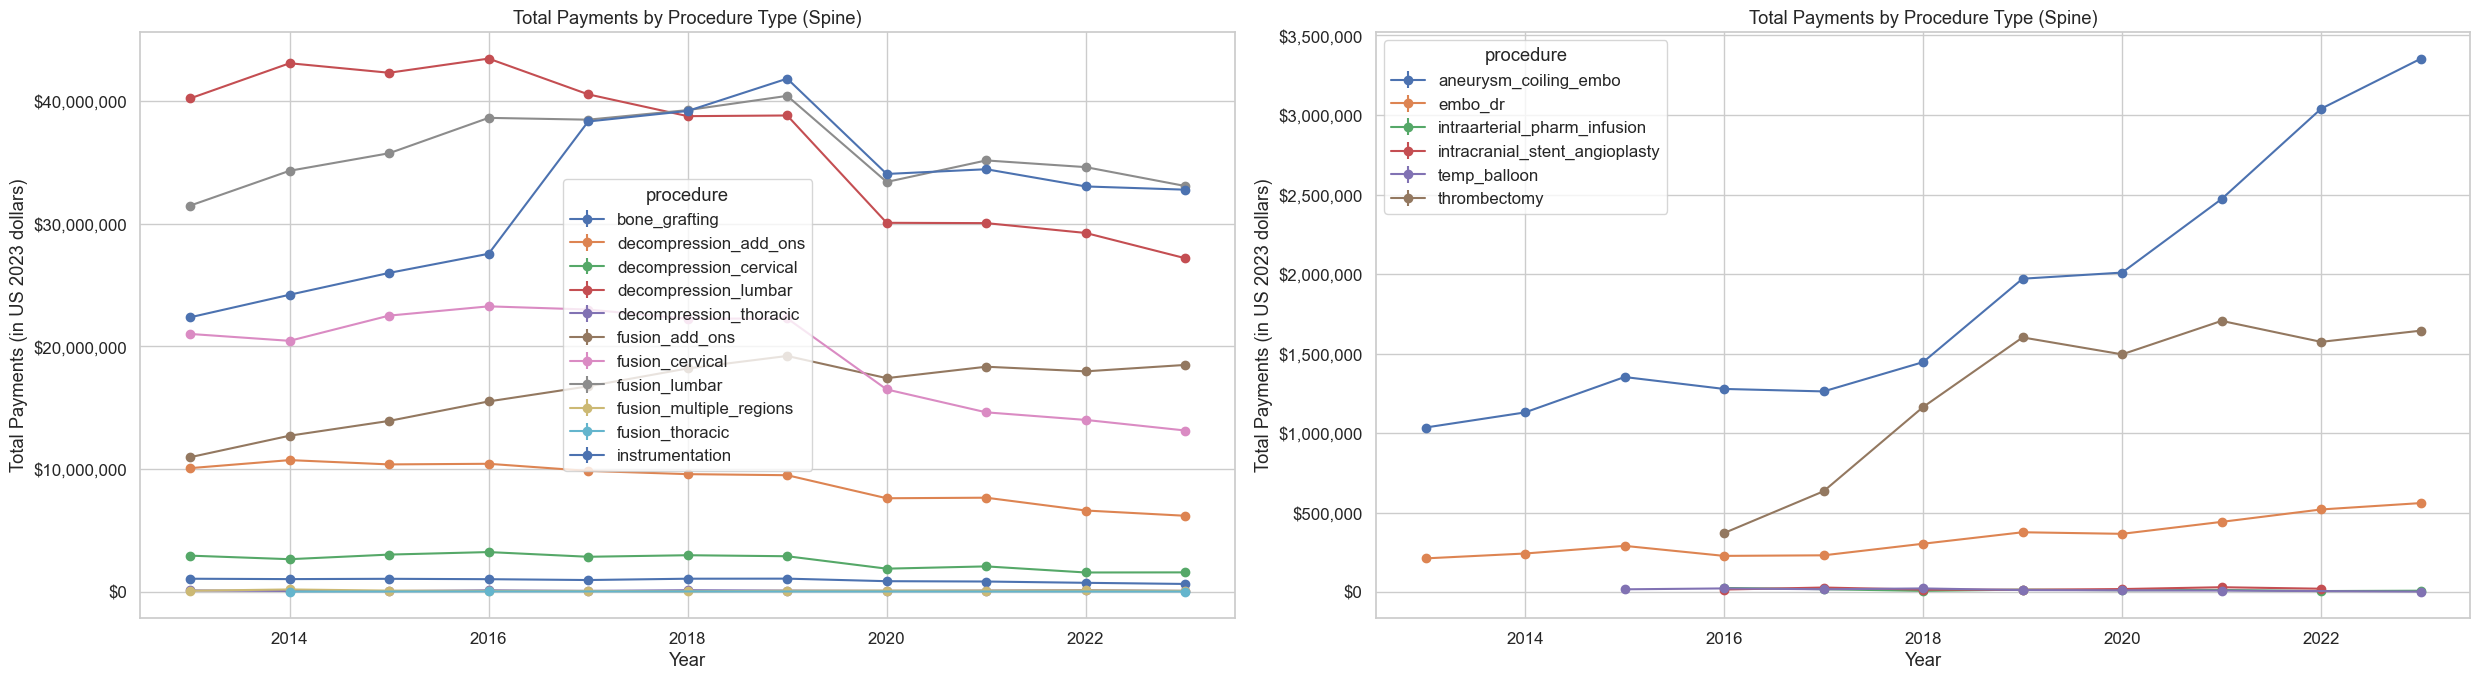

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year']
    y = df_sorted['Sum_Pymt']

    # Compute error bars from CI bounds
    yerr = [
        y - df_sorted['CI_lower_pymt'],
        df_sorted['CI_upper_pymt'] - y
    ]

    axs[0].errorbar(
        x,
        y,
        yerr=yerr,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

axs[0].legend(title=groupby_key)
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Total Payments (in US 2023 dollars)")
axs[0].set_title("Total Payments by Procedure Type (Spine)")

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year']
    y = df_sorted['Sum_Pymt']

    # Compute error bars from CI bounds
    yerr = [
        y - df_sorted['CI_lower_pymt'],
        df_sorted['CI_upper_pymt'] - y
    ]

    axs[1].errorbar(
        x,
        y,
        yerr=yerr,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

axs[1].legend(title=groupby_key)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Total Payments (in US 2023 dollars)")
axs[1].set_title("Total Payments by Procedure Type (Spine)")

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

## Total Payment Growth Rate

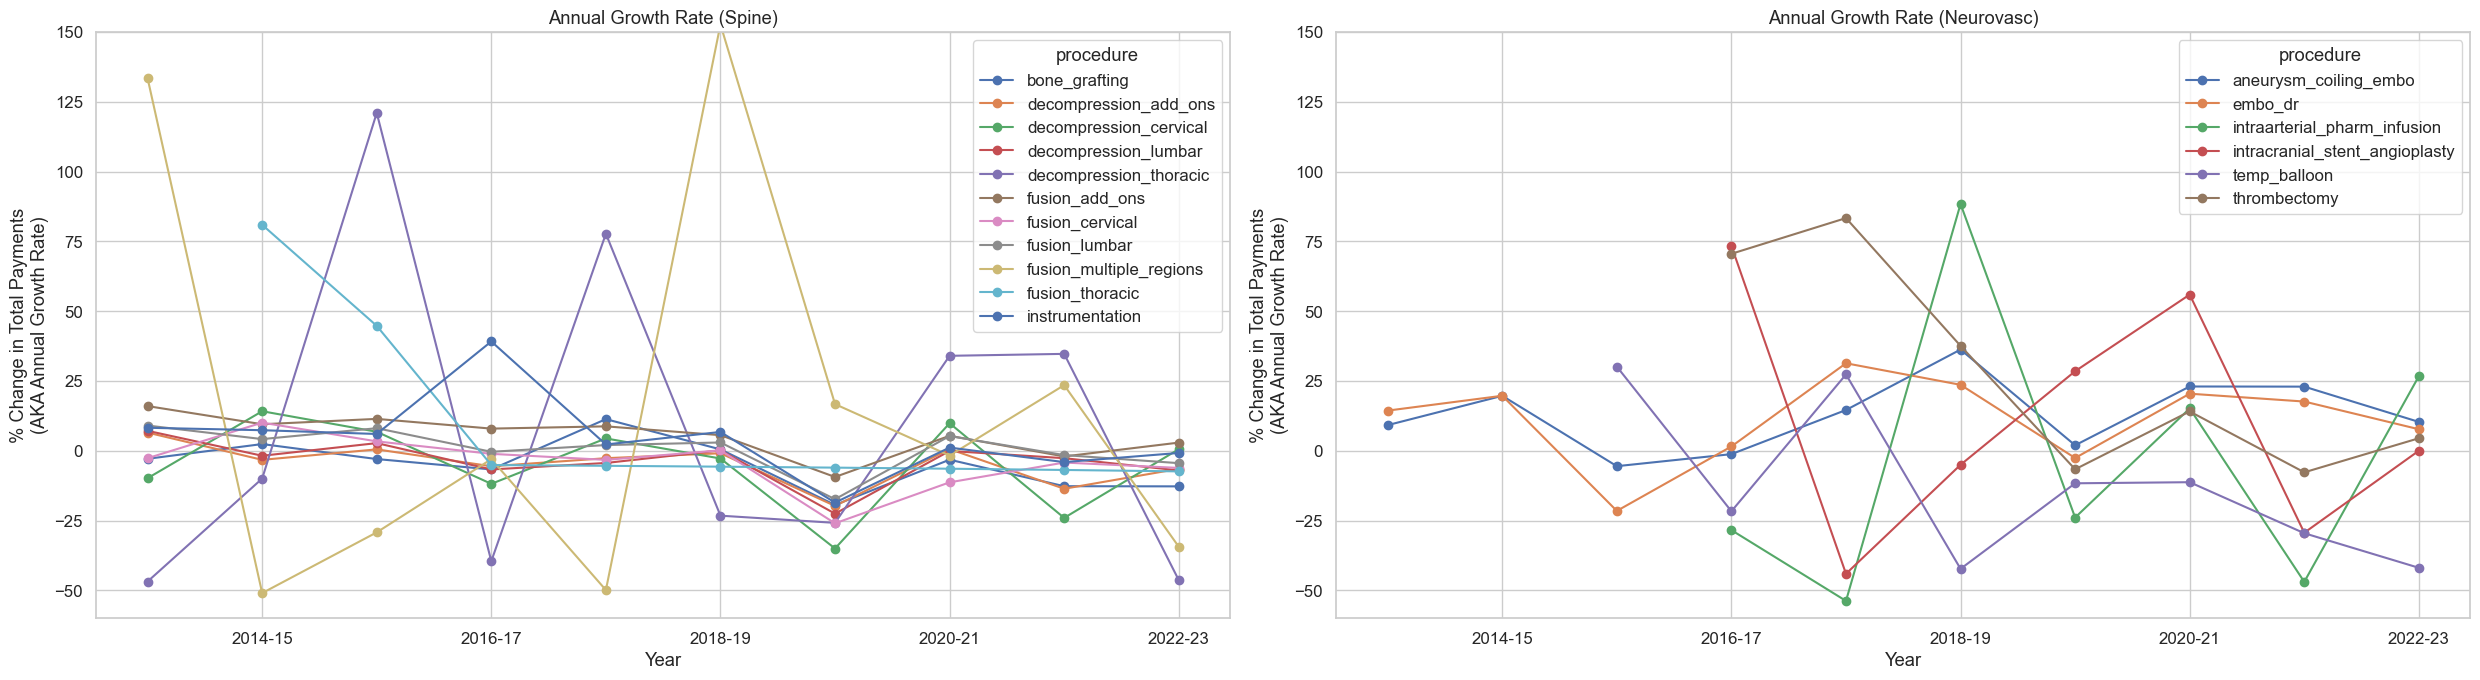

In [188]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

aagr_by_procedure_spine = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    axs[0].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_spine.append([label, np.nanmean(delta)])

axs[0].legend(title=groupby_key)
axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("% Change in Total Payments\n(AKA Annual Growth Rate)")
axs[0].set_ylim([-60, 150])
axs[0].set_title("Annual Growth Rate (Spine)")

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

aagr_by_procedure_neurovasc = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()

    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    axs[1].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_neurovasc.append([label, np.nanmean(delta)])

axs[1].legend(title=groupby_key)
axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("% Change in Total Payments\n(AKA Annual Growth Rate)")
axs[1].set_ylim([-60, 150])
axs[1].set_title("Annual Growth Rate (Neurovasc)")

plt.tight_layout()

In [177]:
pd.DataFrame(aagr_by_procedure_spine + aagr_by_procedure_neurovasc, columns=['procedure', 'AAGR (%)']).sort_values(by=['AAGR (%)'])

,procedure,AAGR (%)
15,temp_balloon,-12.620009
2,decompression_cervical,-4.780821
0,bone_grafting,-4.648402
1,decompression_add_ons,-4.472895
6,fusion_cervical,-4.121567
3,decompression_lumbar,-3.522638
13,intraarterial_pharm_infusion,-3.273415
7,fusion_lumbar,0.775078
10,instrumentation,4.736431
5,fusion_add_ons,5.590256


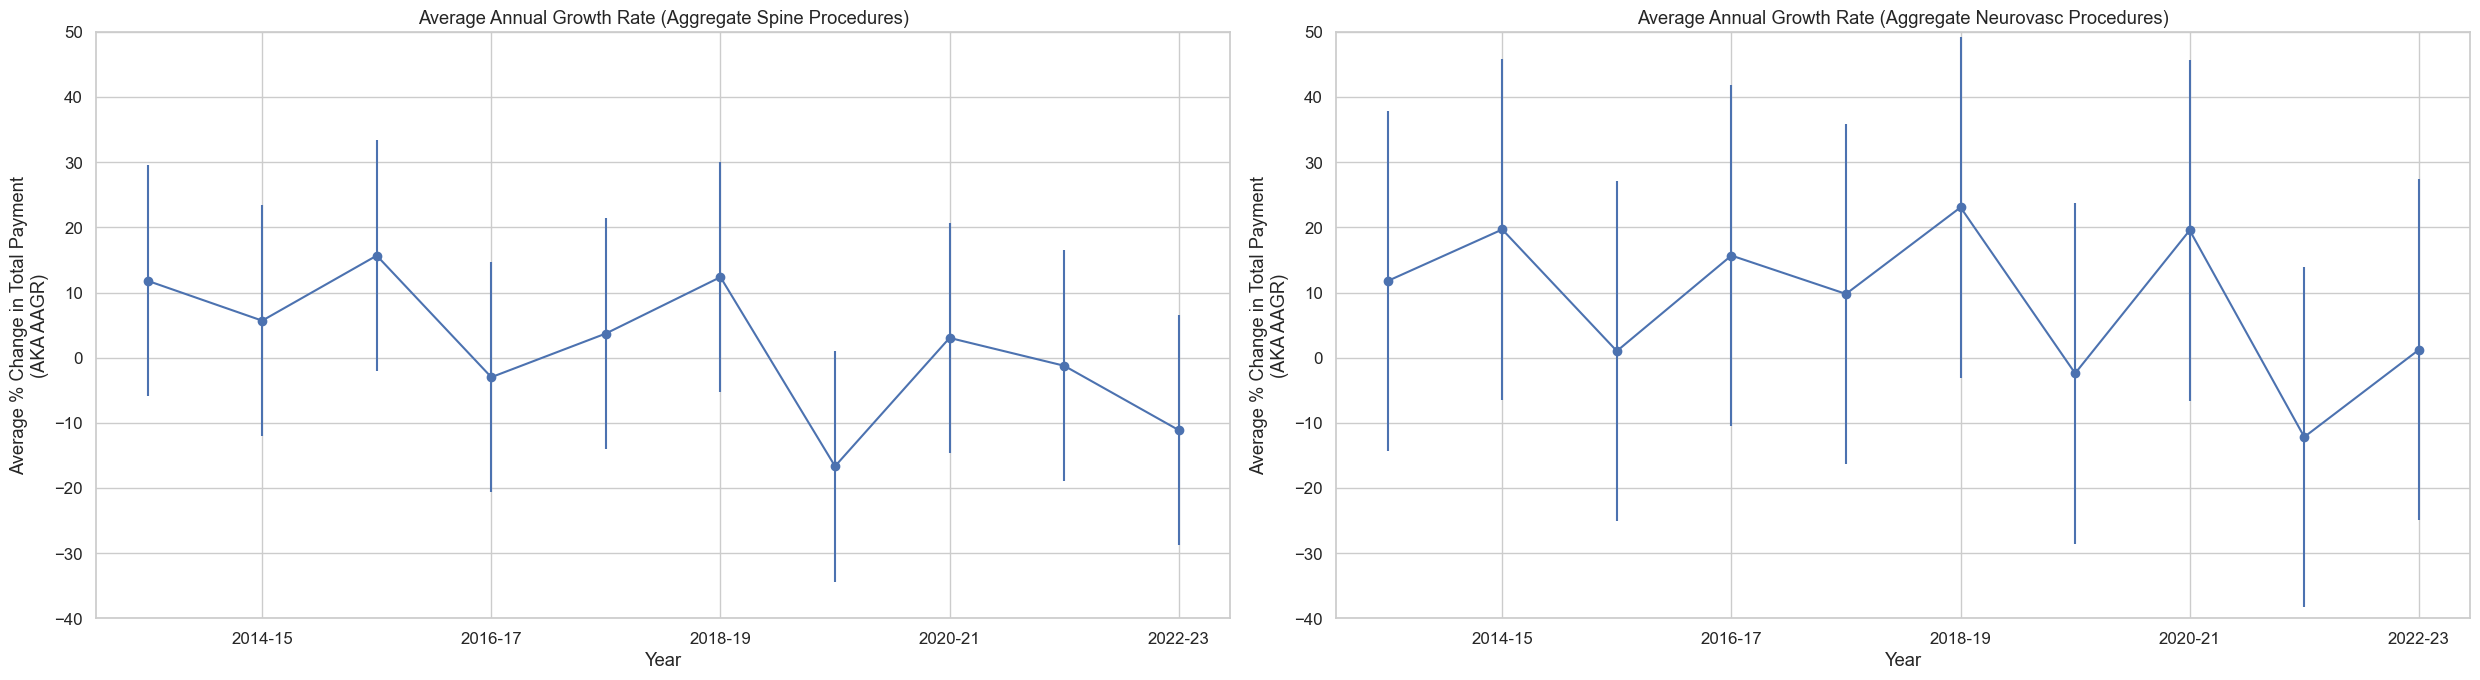

In [189]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[0].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("Average % Change in Total Payment\n(AKA AAGR)")
axs[0].set_ylim([-40, 50])
axs[0].set_title("Average Annual Growth Rate (Aggregate Spine Procedures)")

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append((y_new[i+1] - y_new[i]) / y_new[i] * 100)

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[1].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("Average % Change in Total Payment\n(AKA AAGR)")
axs[1].set_ylim([-40, 50])
axs[1].set_title("Average Annual Growth Rate (Aggregate Neurovasc Procedures)")

plt.tight_layout()

## Total Payment $ Growth

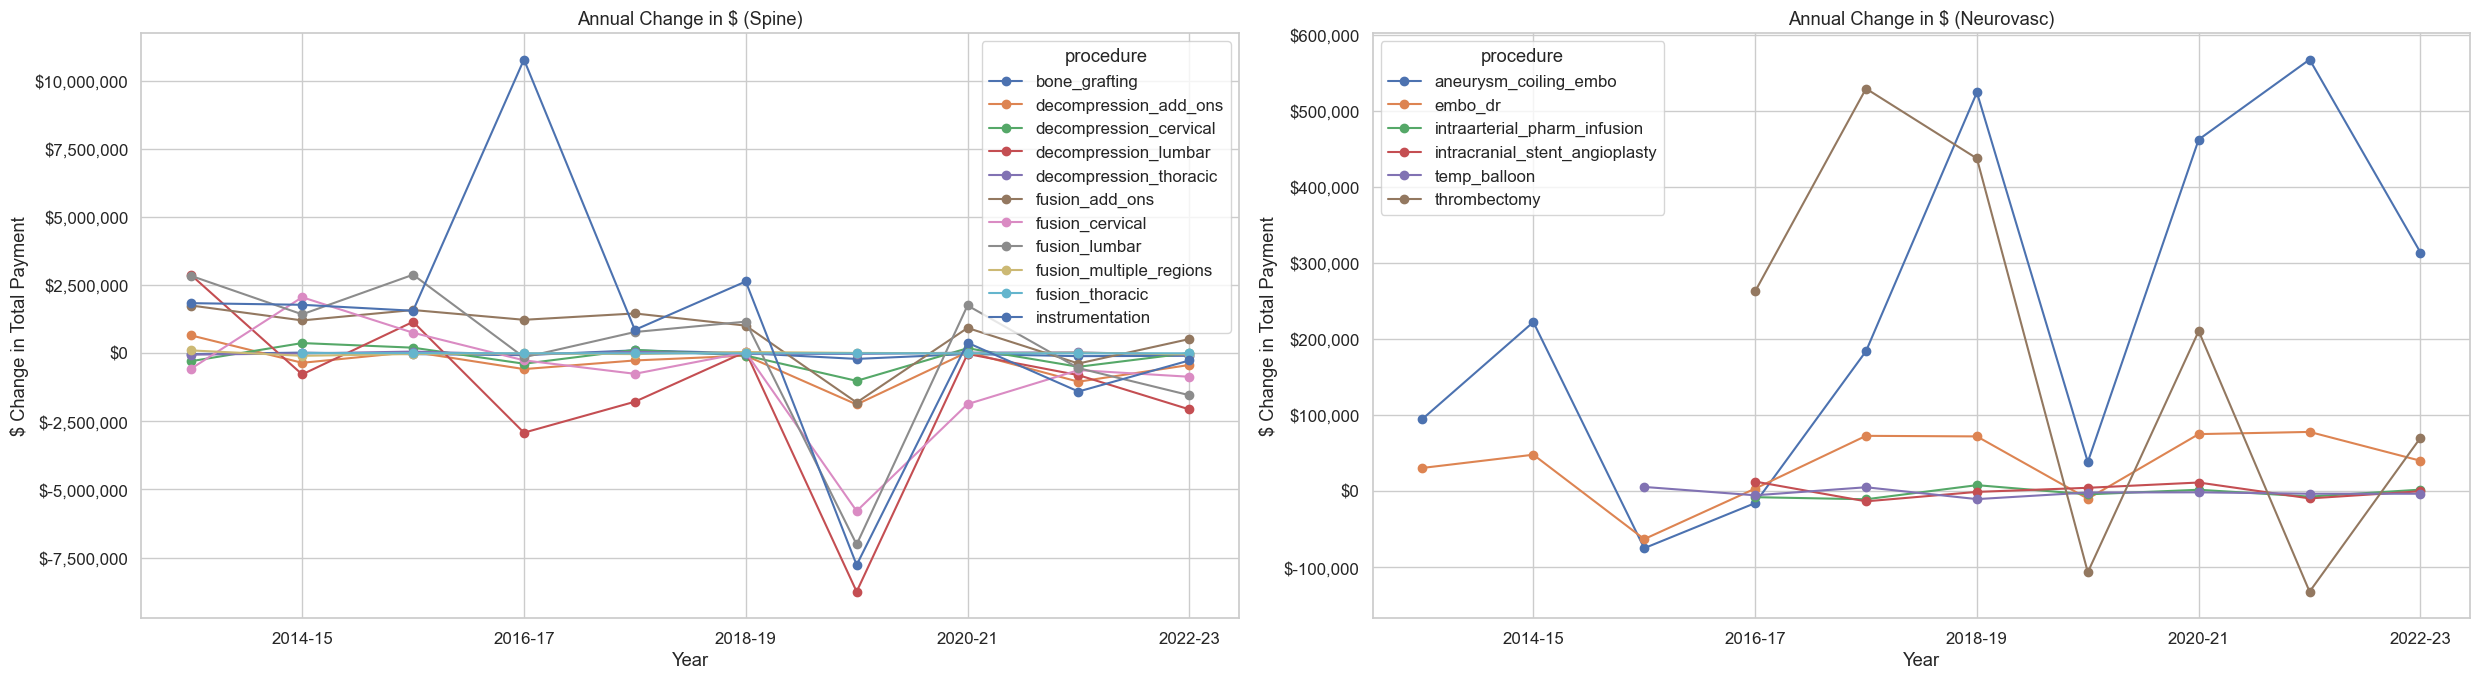

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

aagr_by_procedure_spine = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    axs[0].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_spine.append([label, np.nanmean(delta)])

axs[0].legend(title=groupby_key)
axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("$ Change in Total Payment")
# axs[1].set_ylim([-350, 300])
axs[0].set_title("Annual Change in $ (Spine)")

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

aagr_by_procedure_neurovasc = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        y_new.append(pairs[year] if year in pairs else np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()

    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    axs[1].plot(
        range(len(delta)),
        delta,
        label=label,
        marker='o',
        markersize=6,
        linestyle='-',
    )

    aagr_by_procedure_neurovasc.append([label, np.nanmean(delta)])

axs[1].legend(title=groupby_key)
axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("$ Change in Total Payment")
# axs[1].set_ylim([-350, 300])
axs[1].set_title("Annual Change in $ (Neurovasc)")

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

In [209]:
temp = pd.DataFrame(aagr_by_procedure_spine + aagr_by_procedure_neurovasc, columns=['procedure', 'Change in $']).sort_values(by=['Change in $'])
temp['Change in $'] = temp['Change in $'].apply(lambda x: f'${x:,.2f}'.format(x))
temp

,procedure,Change in $
3,decompression_lumbar,"$-1,303,163.07"
6,fusion_cervical,"$-787,299.83"
1,decompression_add_ons,"$-388,384.74"
2,decompression_cervical,"$-136,439.44"
0,bone_grafting,"$-42,520.69"
4,decompression_thoracic,"$-4,013.01"
13,intraarterial_pharm_infusion,"$-2,478.70"
15,temp_balloon,"$-1,788.79"
8,fusion_multiple_regions,$-600.19
9,fusion_thoracic,$653.31


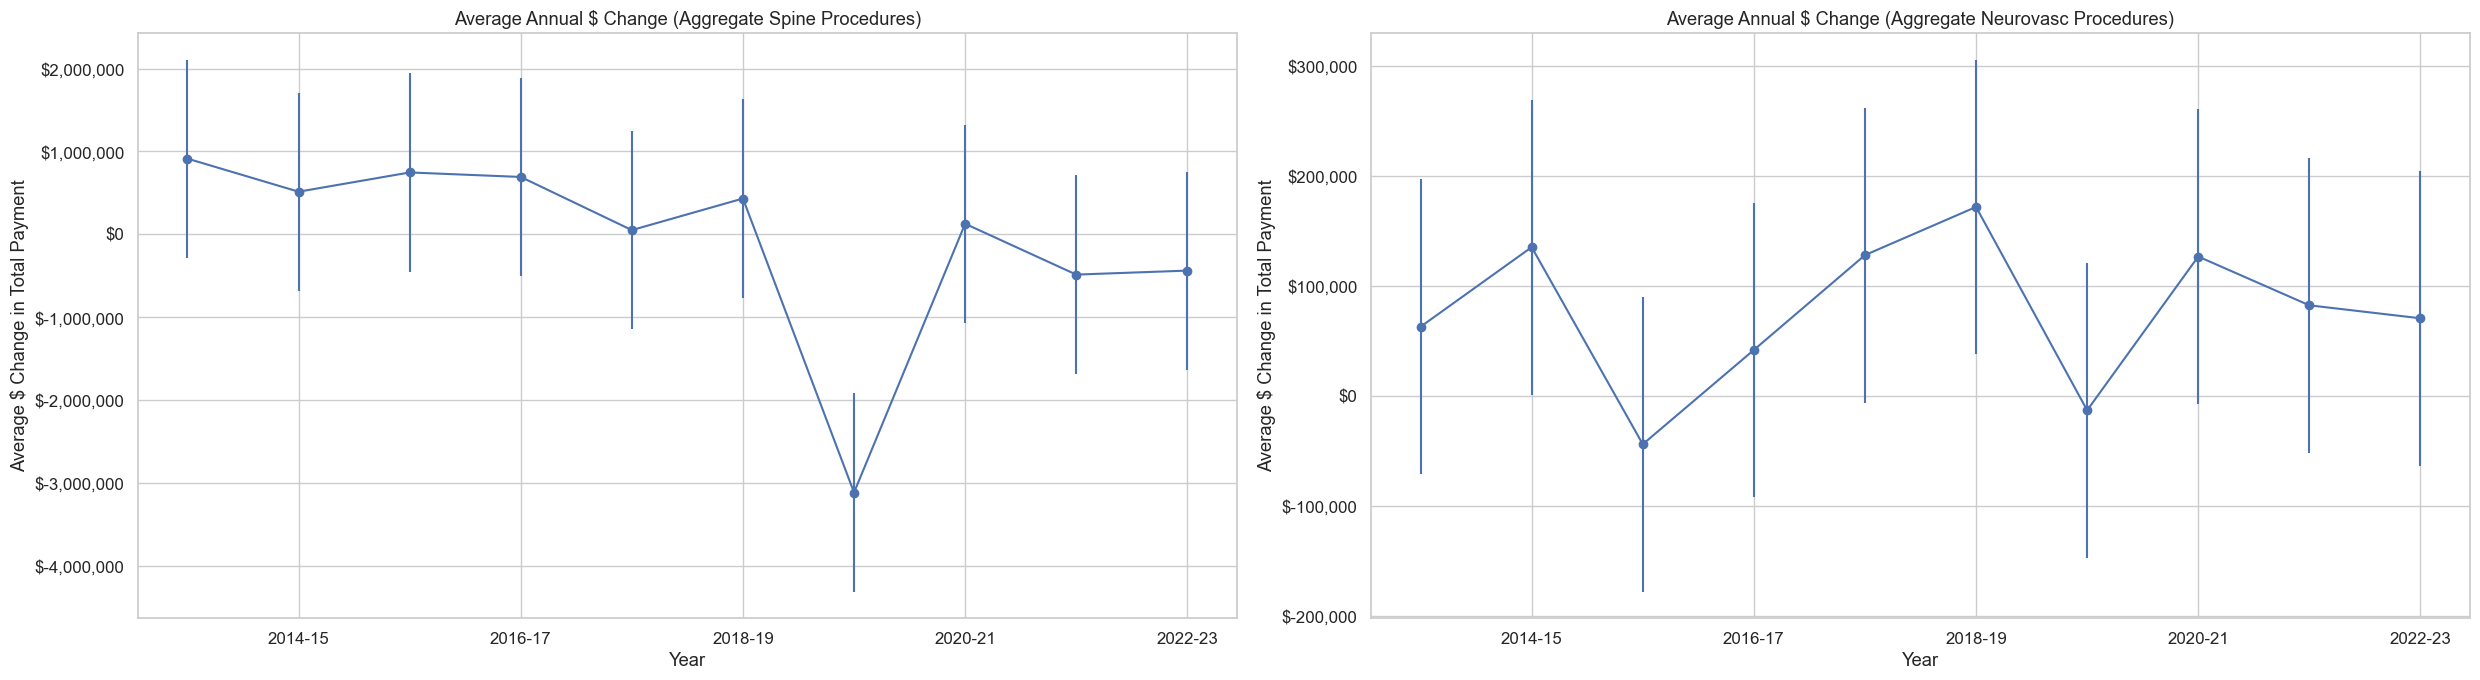

In [210]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 
grouped = util_2023_2013_adj_spine.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[0].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[0].set_xlabel("Year")
axs[0].set_xticks([1, 3, 5, 7, 9])
axs[0].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[0].set_ylabel("Average $ Change in Total Payment")
# axs[0].set_ylim([-40, 50])
axs[0].ticklabel_format(style='plain', axis='y')
axs[0].set_title("Average Annual $ Change (Aggregate Spine Procedures)")

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

grouped = util_2023_2013_adj_neurovasc.groupby(groupby_key)

all_deltas = []
for label, df in grouped:
    # Sort by year to ensure proper line plotting
    df_sorted = df.sort_values('year')
    
    x = df_sorted['year'].tolist()
    y = df_sorted['Sum_Pymt'].tolist()

    pairs = {x[i]: item for i, item in enumerate(y)}

    x_new = list(range(2013, 2024))
    y_new = []
    for year in x_new:
        if year in pairs:
            y_new.append(pairs[year])
        else:
            y_new.append(np.nan)

    y_new = pd.Series(y_new).interpolate().to_numpy()
    
    delta = []
    for i in range(len(y_new) - 1):
        delta.append(y_new[i+1] - y_new[i])

    all_deltas.append(delta)

all_deltas = pd.DataFrame(all_deltas).to_numpy()
aagr = np.nanmean(all_deltas, axis=0)
sem = np.nanstd(np.array(all_deltas), ddof=1) / np.sqrt(len(all_deltas))

ci_lower = aagr - 1.96 * sem
ci_upper = aagr + 1.96 * sem

# Compute error bars from CI bounds
yerr = [aagr - ci_lower, ci_upper - aagr]

axs[1].errorbar(
    range(len(aagr)),
    aagr,
    yerr=yerr,
    marker='o',
    markersize=6,
    linestyle='-',
)

axs[1].set_xlabel("Year")
axs[1].set_xticks([1, 3, 5, 7, 9])
axs[1].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
axs[1].set_ylabel("Average $ Change in Total Payment")
# axs[1].set_ylim([-40, 50])
axs[1].set_title("Average Annual $ Change (Aggregate Neurovasc Procedures)")

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

# Seaborn

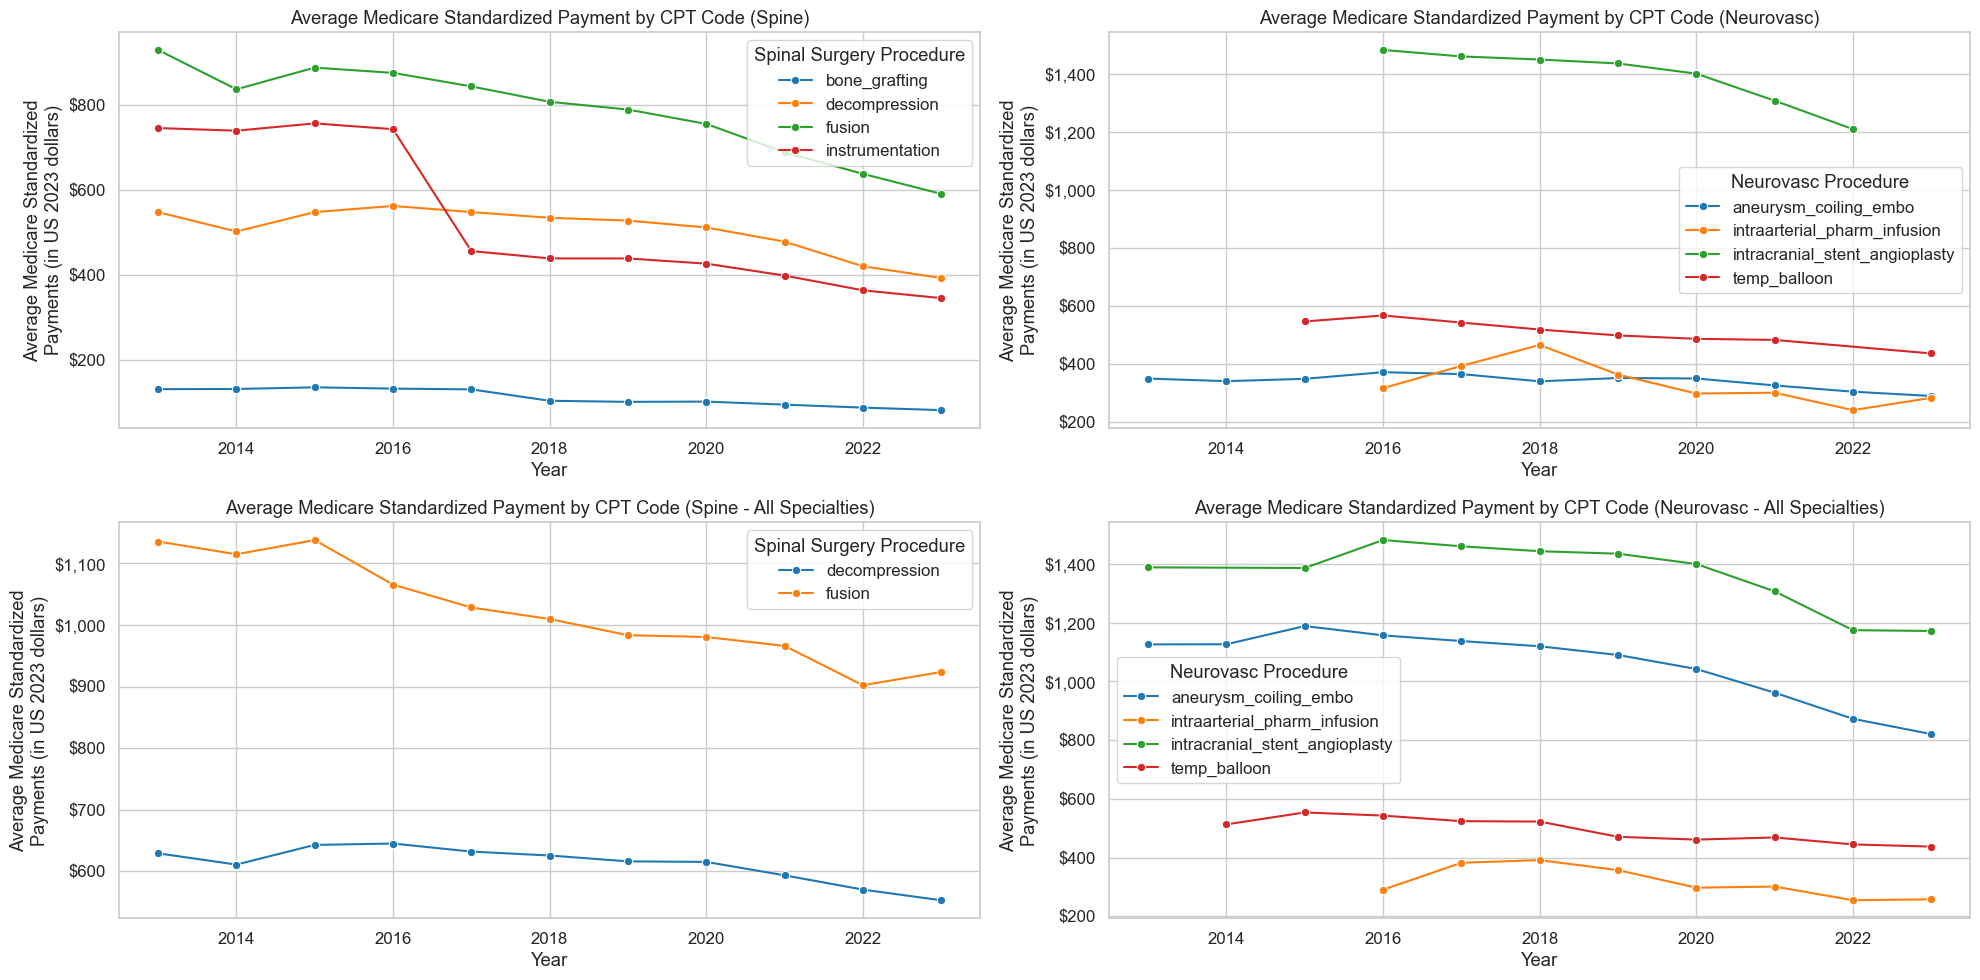

In [110]:
# Set plot style
fig, axs = plt.subplots(2, 2, figsize=(20, 10)) 

# Create the plot for spine
sns.lineplot(
    data=util_2023_2013_adj_spine,
    x="year",
    y="Avg_Price_per_service_adjusted",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[0][0]
)

# Format y-axis as currency
axs[0][0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Title and labels
axs[0][0].set_title("Average Medicare Standardized Payment by CPT Code (Spine)")
axs[0][0].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[0][0].set_xlabel("Year")

# Adjust legend
axs[0][0].legend(title=f"Spinal Surgery {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

# Create the plot for neurovasc
sns.lineplot(
    data=util_2023_2013_adj_neurovasc,
    x="year",
    y="Avg_Price_per_service_adjusted",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[0][1]
)

# Format y-axis as currency
axs[0][1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Title and labels
axs[0][1].set_title("Average Medicare Standardized Payment by CPT Code (Neurovasc)")
axs[0][1].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[0][1].set_xlabel("Year")

# Adjust legend
axs[0][1].legend(title=f"Neurovasc {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

# Create the plot for spine (all specialties)
sns.lineplot(
    data=util_2023_2013_adj_spine_all,
    x="year",
    y="Avg_Price_per_service_adjusted",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[1][0]
)

# Format y-axis as currency
axs[1][0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Title and labels
axs[1][0].set_title("Average Medicare Standardized Payment by CPT Code (Spine - All Specialties)")
axs[1][0].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[1][0].set_xlabel("Year")

# Adjust legend
axs[1][0].legend(title=f"Spinal Surgery {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

# Create the plot for neurovasc (all specialties)
sns.lineplot(
    data=util_2023_2013_adj_neurovasc_all,
    x="year",
    y="Avg_Price_per_service_adjusted",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[1][1]
)

# Format y-axis as currency
axs[1][1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Title and labels
axs[1][1].set_title("Average Medicare Standardized Payment by CPT Code (Neurovasc - All Specialties)")
axs[1][1].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[1][1].set_xlabel("Year")

# Adjust legend
axs[1][1].legend(title=f"Neurovasc {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

plt.tight_layout()
plt.show()

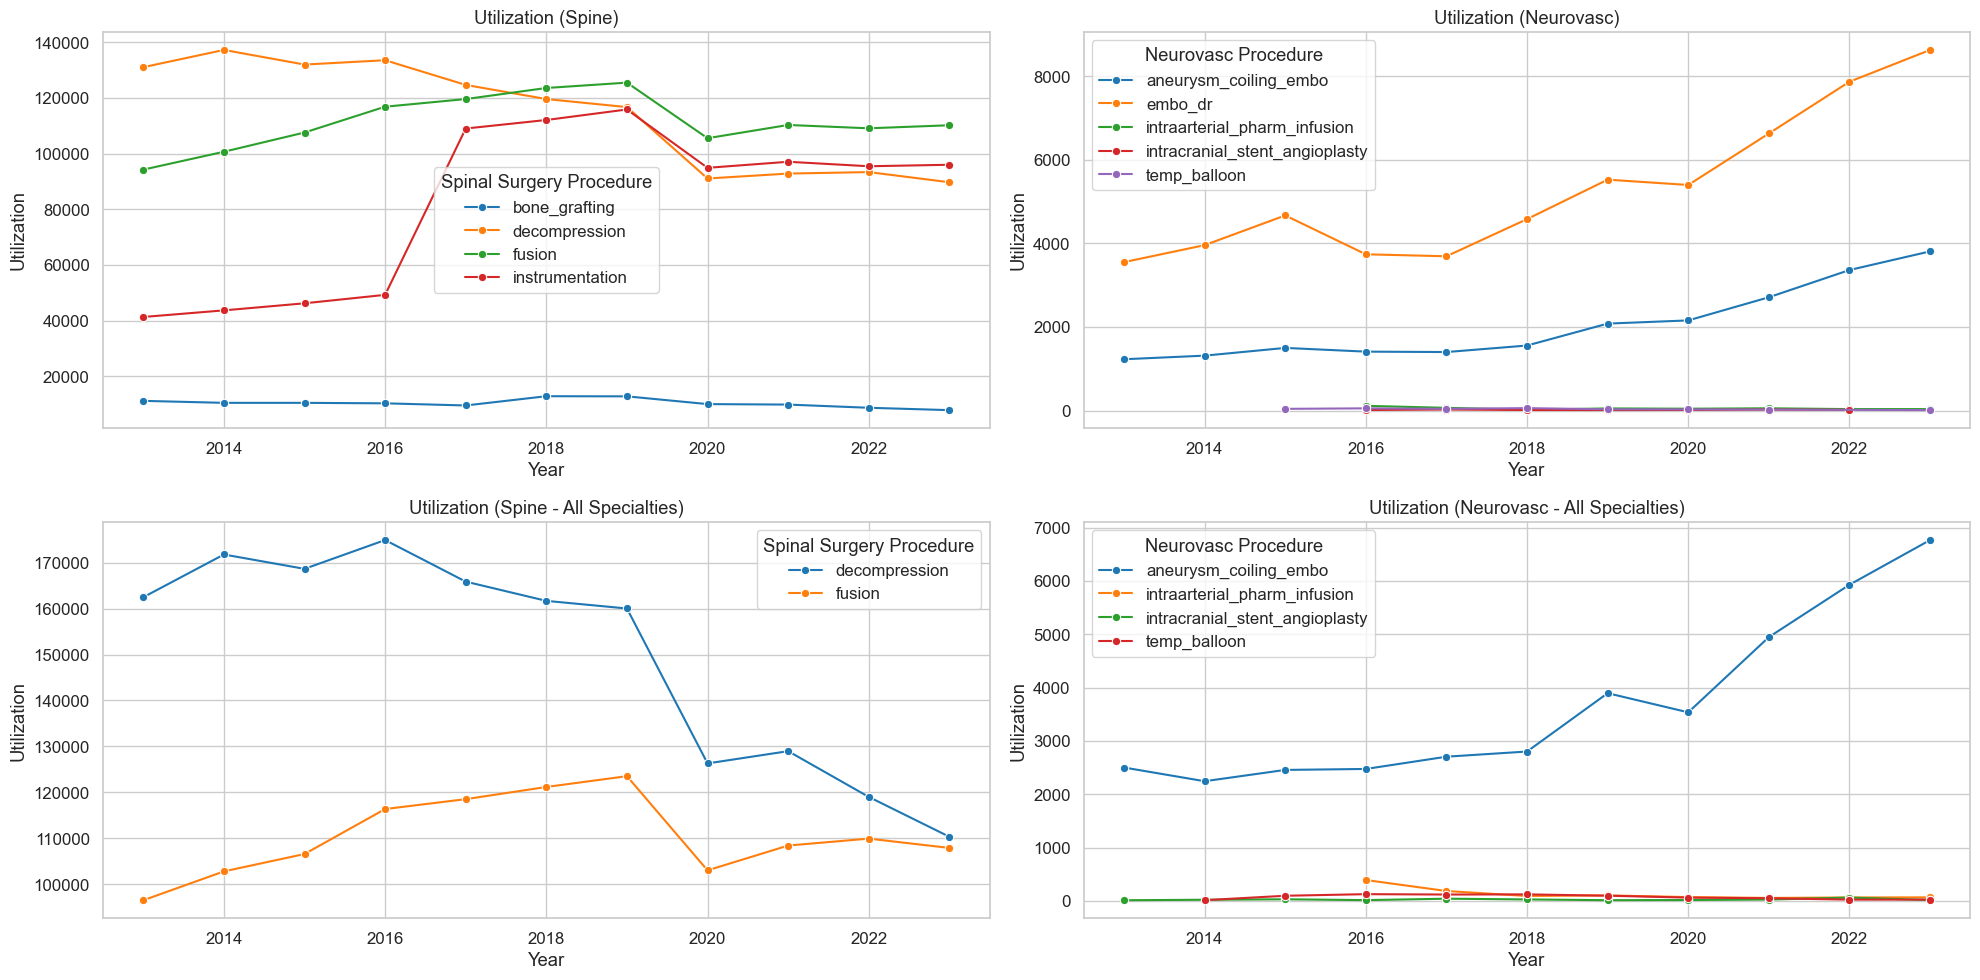

In [225]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axs = plt.subplots(2, 2, figsize=(20, 10)) 

# Create the plot for spine
sns.lineplot(
    data=util_2023_2013_adj_spine,
    x="year",
    y="Sum_Utilization",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[0][0]
)

# Title and labels
axs[0][0].set_title("Utilization (Spine)")
axs[0][0].set_ylabel("Utilization")
axs[0][0].set_xlabel("Year")

# Adjust legend
axs[0][0].legend(title=f"Spinal Surgery {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

# Create the plot for neurovasc
sns.lineplot(
    data=util_2023_2013_adj_neurovasc,
    x="year",
    y="Sum_Utilization",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[0][1]
)

# Title and labels
axs[0][1].set_title("Utilization (Neurovasc)")
axs[0][1].set_ylabel("Utilization")
axs[0][1].set_xlabel("Year")

# Adjust legend
axs[0][1].legend(title=f"Neurovasc {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

# Create the plot for spine (all specialties)
sns.lineplot(
    data=util_2023_2013_adj_spine_all,
    x="year",
    y="Sum_Utilization",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[1][0]
)

# Title and labels
axs[1][0].set_title("Utilization (Spine - All Specialties)")
axs[1][0].set_ylabel("Utilization")
axs[1][0].set_xlabel("Year")

# Adjust legend
axs[1][0].legend(title=f"Spinal Surgery {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

# Create the plot for neurovasc (all specialties)
sns.lineplot(
    data=util_2023_2013_adj_neurovasc_all,
    x="year",
    y="Sum_Utilization",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[1][1]
)

# Title and labels
axs[1][1].set_title("Utilization (Neurovasc - All Specialties)")
axs[1][1].set_ylabel("Utilization")
axs[1][1].set_xlabel("Year")

# Adjust legend
axs[1][1].legend(title=f"Neurovasc {'Procedure' if groupby_key == 'procedure' else 'CPT Code'}")

plt.tight_layout()
plt.show()